In [ ]:
pip install -U albumentations

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.ops import MultiScaleRoIAlign, RoIPool
from torch.utils.data import DataLoader
import numpy as np
import os
import subprocess
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
# Download training images
#!wget http://images.cocodataset.org/zips/train2017.zip

# Download validation images
!wget http://images.cocodataset.org/zips/val2017.zip

# Download COCO annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2025-03-17 22:09:19--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.89.67, 3.5.24.172, 52.216.8.195, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.89.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  57.1MB/s    in 14s     

2025-03-17 22:09:33 (54.9 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2025-03-17 22:09:33--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.203.185, 52.216.248.172, 52.216.140.244, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.203.185|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva

In [ ]:
#!unzip -o train2017.zip
!unzip -o val2017.zip
!unzip -o annotations_trainval2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/00000019

In [ ]:
# Custom Region Proposal Network (RPN)
class RPN(nn.Module):
    def __init__(self, in_channels, num_anchors):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 512, kernel_size=3, stride=1, padding=1)
        self.cls_logits = nn.Conv2d(512, num_anchors, kernel_size=1)
        self.bbox_pred = nn.Conv2d(512, num_anchors * 4, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv(x))
        logits = self.cls_logits(x)
        bbox_pred = self.bbox_pred(x)
        return logits, bbox_pred

In [ ]:
class BoxHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, 1024)  # ✅ Input should be 12544
        self.fc2 = nn.Linear(1024, 1024)
        self.cls_score = nn.Linear(1024, num_classes)  # ✅ Class logits
        self.bbox_pred = nn.Linear(1024, num_classes * 4)  # ✅ Bounding box regression

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        cls_logits = self.cls_score(x)  # ✅ Class Scores
        bbox_preds = self.bbox_pred(x)  # ✅ Box Predictions
        return cls_logits, bbox_preds


In [ ]:
# Custom Mask Head (Fully Convolutional Layers)
class MaskHead(nn.Module):
    def __init__(self, in_channels, hidden_dim=256, num_classes=91):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(hidden_dim, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        return x


In [ ]:
import torchvision.models.detection.backbone_utils as backbone_utils
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

def get_resnet_backbone():
    backbone = resnet_fpn_backbone("resnet50", weights="DEFAULT")  # ✅ Use ResNet50 with FPN
    return backbone


In [ ]:
class MaskRCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = get_resnet_backbone()  # ✅ Use Pretrained ResNet
        self.rpn = RPN(2048, num_anchors=9)
        self.roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"], output_size=7, sampling_ratio=2)
        self.box_head = BoxHead(7 * 7 * 256, num_classes)  # ✅ Bounding Box Head
        self.mask_head = MaskHead(256, num_classes=num_classes)  # ✅ Mask Head

    def forward(self, images, proposals=None):
        features = self.backbone(images)  # ✅ Extract features

        # ✅ Fix `feature_dict` to correctly handle different backbone outputs
        if isinstance(features, dict):
            feature_dict = features  # ✅ Already a dictionary (FPN case)
        elif isinstance(features, list):
            feature_dict = {str(i): feat for i, feat in enumerate(features)}  # ✅ Convert list to dict
        else:
            feature_dict = {"0": features}  # ✅ Single tensor case (No FPN)

        # ✅ Generate proposals if not provided
        if proposals is None:
            rpn_logits, rpn_bbox = self.rpn(features)
            proposals = rpn_bbox

        # ✅ Fix `image_shapes` format
        image_shapes = [(images.shape[-2], images.shape[-1])] * images.shape[0]

        # ✅ Convert `proposals` into List[Tensor]
        proposals_per_image = []
        batch_size = images.shape[0]

        for i in range(batch_size):
            mask = proposals[:, 0] == i  # ✅ Select proposals for image `i`
            if mask.sum() == 0:  # ✅ Handle empty proposals
                proposals_per_image.append(torch.empty((0, 4), dtype=proposals.dtype, device=proposals.device))
            else:
                proposals_per_image.append(proposals[mask][:, 1:])  # ✅ Remove batch index column

        # ✅ Apply RoI Align
        pooled_regions = self.roi_pool(feature_dict, proposals_per_image, image_shapes)

        # ✅ Ensure `pooled_regions` is not empty
        if pooled_regions.numel() == 0:
            raise ValueError("❌ RoIAlign produced empty regions, check proposals input.")

        # ✅ Ensure correct shape before passing to BoxHead
        if pooled_regions.dim() != 4:
            raise ValueError(f"❌ Expected 4D tensor (N, C, 7, 7), got {pooled_regions.shape}")

        # ✅ Get feature map size
        C, H, W = pooled_regions.shape[1], pooled_regions.shape[2], pooled_regions.shape[3]
        expected_size = C * H * W  # Should be 256 * 7 * 7 = 12544

        # ✅ Ensure correct reshaping
        if expected_size != 12544:
            raise ValueError(f"❌ Feature map has incorrect channels: {C}. Expected 256.")

        flattened_pooled = pooled_regions.view(pooled_regions.size(0), expected_size)

        # ✅ Debugging Print (Optional)
        if batch_idx == 0:  # ✅ Print only for the first batch of each epoch
           print(f"✅ Reshaped pooled_regions: Expected {expected_size}, Got {flattened_pooled.shape[1]}")


        # ✅ Compute Class & Box Predictions
        class_logits, bbox_deltas = self.box_head(flattened_pooled)

        # ✅ Compute Mask Predictions
        masks = self.mask_head(pooled_regions)

        return class_logits, bbox_deltas, masks


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.ops import RoIAlign
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import os
import json
import time
from PIL import Image
from pycocotools.coco import COCO

# ✅ Set Device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# ✅ COCO Dataset Class (Optimized)
class COCODataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.img_ids = list(self.coco.imgs.keys())[:50000]  # ✅ Use only 20,000 images
        self.transform = transform
        self.img_size = (128, 128)  # ✅ Resize to 128x128 for faster training

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        # ✅ Resize image
        image = image.resize(self.img_size, Image.BILINEAR)

        # Get bounding boxes & masks
        boxes, masks, labels = [], [], []

        for ann in anns:
            x, y, w, h = ann['bbox']
            x1, y1, x2, y2 = x, y, x + w, y + h
            boxes.append([x1, y1, x2, y2])

            mask = self.coco.annToMask(ann)
            mask = cv2.resize(mask, self.img_size)  # Resize mask
            masks.append(mask)

            labels.append(ann['category_id'])

        # ✅ Handle Empty Annotations
        if len(boxes) == 0 or len(labels) == 0:
            return self.__getitem__((idx + 1) % len(self.img_ids))  # Skip empty images

        # ✅ Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32).reshape(-1, 4)  # Shape (N, 4)
        masks = torch.tensor(np.array(masks), dtype=torch.uint8).unsqueeze(1)  # Shape (N, 1, H, W)
        labels = torch.tensor(labels, dtype=torch.int64).flatten()  # Shape (N,)

        if self.transform:
            image = self.transform(image)

        return image, boxes, masks, labels

# ✅ Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.RandomHorizontalFlip(p=0.5),  # ✅ Flip images randomly
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # ✅ Improve feature learning
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  # ✅ Reduce noise
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ✅ Normalize using ImageNet stats
])

# ✅ Collate Function to Handle Variable-Sized Batches
def collate_fn(batch):
    images, boxes, masks, labels = zip(*batch)
    images = torch.stack(images, dim=0)  # Stack images into a single tensor
    return images, boxes, masks, labels  # Keep boxes/masks/lables as lists

# ✅ Create Dataset & DataLoader (Optimized)
train_dataset = COCODataset("train2017", "annotations/instances_train2017.json", transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=4)

# ✅ Check Dataset
print(f"Total images in dataset: {len(train_dataset)}")
for images, boxes, masks, labels in train_loader:
    print(f"Batch size: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Boxes shape: {boxes[0].shape}")
    print(f"Masks shape: {masks[0].shape}")
    print(f"Labels: {labels[0]}")
    break  # ✅ Stop after first batch check


Using Device: cuda
loading annotations into memory...
Done (t=16.87s)
creating index...
index created!
Total images in dataset: 50000
Batch size: 16
Image shape: torch.Size([3, 128, 128])
Boxes shape: torch.Size([7, 4])
Masks shape: torch.Size([7, 1, 128, 128])
Labels: tensor([ 1,  1,  1, 88,  1,  1,  1])


In [ ]:
# Approach 1

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms

# ✅ Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Load Model & Optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MaskRCNN(num_classes=91).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# ✅ Loss Functions
loss_fn_cls = nn.CrossEntropyLoss(label_smoothing=0.2)
loss_fn_bbox = nn.SmoothL1Loss()
loss_fn_mask = nn.BCEWithLogitsLoss()

scaler = GradScaler()

# ✅ Training Loop
epochs = 50
accumulate_steps = 4

for epoch in range(epochs):
    model.train()
    start_time = time.time()
    total_loss, correct_preds, total_preds = 0, 0, 0

    for batch_idx, (images, boxes, masks, labels) in enumerate(train_loader):
        images = torch.stack([img.to(device) for img in images])
        boxes = [b.to(device) for b in boxes]
        masks = [m.to(device) for m in masks]
        labels = [l.to(device) for l in labels]

        # ✅ Skip Empty Labels to Prevent Errors
        if len(labels) == 0 or len(boxes) == 0:
            print(f"⚠️ Skipping batch {batch_idx} due to empty labels/boxes")
            continue

        # ✅ Normalize & Clamp Bounding Boxes
        for i in range(len(boxes)):
            image_w, image_h = images.shape[3], images.shape[2]
            boxes[i] /= torch.tensor([image_w, image_h, image_w, image_h], device=device)
            boxes[i] = torch.clamp(boxes[i], min=0, max=1)

        num_proposals = min(15, max(len(b) for b in boxes))
        proposals, proposal_labels, proposal_boxes = [], [], []

        for i, (b, l) in enumerate(zip(boxes, labels)):
            if len(b) == 0:
                continue
            b_idx = torch.full((b.shape[0], 1), i, dtype=torch.float32, device=device)
            formatted_boxes = torch.cat((b_idx, b[:, :4]), dim=1)
            proposals.append(formatted_boxes[:num_proposals])
            proposal_labels.append(l[:num_proposals])
            proposal_boxes.append(b[:num_proposals])

        if len(proposals) > 0:
            proposals = torch.cat(proposals, dim=0).to(device)
            proposal_labels = torch.cat(proposal_labels, dim=0).to(device)
            proposal_boxes = torch.cat(proposal_boxes, dim=0).to(device)
        else:
            proposals = torch.zeros((1, 5), dtype=torch.float32, device=device)
            proposal_labels = torch.zeros((1,), dtype=torch.int64, device=device)
            proposal_boxes = torch.zeros((1, 4), dtype=torch.float32, device=device)

        # ✅ Forward Pass with Mixed Precision
        with autocast():
            class_logits, bbox_deltas, mask_logits = model(images, proposals)

        # ✅ Compute Losses
        loss_cls = loss_fn_cls(class_logits, proposal_labels)
        selected_bbox_deltas = bbox_deltas.view(-1, 91, 4)
        predicted_classes = torch.argmax(class_logits, dim=1)
        selected_bbox_deltas = selected_bbox_deltas[torch.arange(selected_bbox_deltas.size(0)), predicted_classes]
        loss_bbox = loss_fn_bbox(selected_bbox_deltas, proposal_boxes)

        resized_masks = F.interpolate(masks[0].float(), size=mask_logits.shape[-2:], mode="bilinear", align_corners=False)

        # ✅ Ensure masks match mask_logits channels
        if resized_masks.shape[1] == 1 and mask_logits.shape[1] > 1:
            resized_masks = resized_masks.repeat(1, mask_logits.shape[1], 1, 1)
        elif resized_masks.shape[1] > 1 and mask_logits.shape[1] == 1:
            resized_masks = resized_masks[:, :1, :, :]

        # ✅ Ensure batch sizes match
        if resized_masks.shape[0] < mask_logits.shape[0]:
            pad_size = mask_logits.shape[0] - resized_masks.shape[0]
            padding = torch.zeros((pad_size, mask_logits.shape[1], *mask_logits.shape[-2:]), dtype=resized_masks.dtype, device=resized_masks.device)
            resized_masks = torch.cat([resized_masks, padding], dim=0)
        elif resized_masks.shape[0] > mask_logits.shape[0]:
            resized_masks = resized_masks[:mask_logits.shape[0]]

        loss_mask = loss_fn_mask(mask_logits, resized_masks)

        # ✅ Total Loss (Normalized)
        loss = (loss_cls + loss_bbox + loss_mask) / len(images)

        # ✅ Convert NaN Losses to Zero & Skip Unstable Batches
        loss = torch.nan_to_num(loss, nan=0.0, posinf=0.0, neginf=0.0)
        if loss == 0 or torch.isnan(loss) or torch.isinf(loss):
            print(f"⚠️ Skipping batch {batch_idx} due to unstable loss")
            optimizer.zero_grad()
            continue

        # ✅ Gradient Accumulation with Clipping
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        if (batch_idx + 1) % accumulate_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

        preds = torch.argmax(class_logits, dim=1)
        labels_flat = torch.cat(proposal_labels, dim=0) if isinstance(proposal_labels, list) else proposal_labels

        # ✅ Track Accuracy
        min_size = min(labels_flat.shape[0], preds.shape[0])
        correct_preds += (preds[:min_size] == labels_flat[:min_size]).sum().item()
        total_preds += min_size

        if batch_idx % 100 == 0:
            print(f"🟢 Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}: Loss {loss.item():.4f}")

    # ✅ Compute Training Accuracy
    scheduler.step()
    train_accuracy = correct_preds / total_preds if total_preds > 0 else 0.0
    epoch_time = time.time() - start_time

    print(f"✅ Epoch {epoch+1} Done: Loss {total_loss:.4f}, Train Acc: {train_accuracy:.4f}, Time: {epoch_time:.2f}s")

    # ✅ Print Learning Rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"📉 Learning Rate after Epoch {epoch+1}: {current_lr:.6f}")


<ipython-input-17-de31e4ba8ac2>:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-17-de31e4ba8ac2>:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Streaming output truncated to the last 5000 lines.
⚠️ Skipping batch 1169 due to unstable loss
⚠️ Skipping batch 1174 due to unstable loss
⚠️ Skipping batch 1178 due to unstable loss
⚠️ Skipping batch 1195 due to unstable loss
⚠️ Skipping batch 1200 due to unstable loss
⚠️ Skipping batch 1216 due to unstable loss
⚠️ Skipping batch 1227 due to unstable loss
⚠️ Skipping batch 1228 due to unstable loss
⚠️ Skipping batch 1237 due to unstable loss
⚠️ Skipping batch 1251 due to unstable loss
⚠️ Skipping batch 1276 due to unstable loss
⚠️ Skipping batch 1279 due to unstable loss
⚠️ Skipping batch 1284 due to unstable loss
⚠️ Skipping batch 1285 due to unstable loss
⚠️ Skipping batch 1286 due to unstable loss
⚠️ Skipping batch 1290 due to unstable loss
⚠️ Skipping batch 1295 due to unstable loss
🟢 Epoch 34, Batch 1300/3125: Loss 0.1590
⚠️ Skipping batch 1309 due to unstable loss
⚠️ Skipping batch 1314 due to unstable loss
⚠️ Skipping batch 1326 due to unstable loss
⚠️ Skipping batch 1337 due t

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_path =  "/content/drive/MyDrive/mask_rcnn_trained_v1.2.pth"  # Change path if needed
torch.save(model.state_dict(), save_path)

print(f"✅ Model saved to Google Drive at {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to Google Drive at /content/drive/MyDrive/mask_rcnn_trained_v1.2.pth


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cuda


In [ ]:
# Load the model for inference or continued training
model = MaskRCNN(num_classes=91).to(device)  # Initialize the model again

# Load the saved weights (state_dict)
checkpoint_path = "/content/drive/MyDrive/mask_rcnn_trained_v1.2.pth"
model.load_state_dict(torch.load(checkpoint_path))
model.eval()  # Set the model to evaluation mode

TypeError: MaskRCNN.__init__() missing 1 required positional argument: 'backbone'

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn.functional import interpolate
from collections import Counter

# ✅ Create Dataset & DataLoader (Optimized)
test_dataset = COCODataset("val2017", "annotations/instances_val2017.json", transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=4)

import torch

def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations for testing
        for batch_idx, (images, boxes, masks, labels) in enumerate(test_loader):
            images = torch.stack([img.to(device) for img in images])
            boxes = [b.to(device) for b in boxes]
            masks = [m.to(device) for m in masks]
            labels = [l.to(device) for l in labels]

            # Skip Empty Labels to Prevent Errors
            if len(labels) == 0 or len(boxes) == 0:
                print(f"⚠️ Skipping batch {batch_idx} due to empty labels/boxes")
                continue

            # Normalize & Clamp Bounding Boxes
            for i in range(len(boxes)):
                image_w, image_h = images.shape[3], images.shape[2]
                boxes[i] /= torch.tensor([image_w, image_h, image_w, image_h], device=device)
                boxes[i] = torch.clamp(boxes[i], min=0, max=1)

            num_proposals = min(15, max(len(b) for b in boxes))
            proposals, proposal_labels, proposal_boxes = [], [], []

            for i, (b, l) in enumerate(zip(boxes, labels)):
                if len(b) == 0:
                    continue
                b_idx = torch.full((b.shape[0], 1), i, dtype=torch.float32, device=device)
                formatted_boxes = torch.cat((b_idx, b[:, :4]), dim=1)
                proposals.append(formatted_boxes[:num_proposals])
                proposal_labels.append(l[:num_proposals])
                proposal_boxes.append(b[:num_proposals])

            # Ensure proposals is a tensor before indexing
            if len(proposals) > 0:
                proposals = torch.cat(proposals, dim=0).to(device)
                proposal_labels = torch.cat(proposal_labels, dim=0).to(device)
                proposal_boxes = torch.cat(proposal_boxes, dim=0).to(device)
            else:
                proposals = torch.zeros((1, 5), dtype=torch.float32, device=device)
                proposal_labels = torch.zeros((1,), dtype=torch.int64, device=device)
                proposal_boxes = torch.zeros((1, 4), dtype=torch.float32, device=device)

            # Forward Pass with Mixed Precision
            class_logits, bbox_deltas, mask_logits = model(images, proposals)

            preds = torch.argmax(class_logits, dim=1)
            labels_flat = torch.cat(proposal_labels, dim=0) if isinstance(proposal_labels, list) else proposal_labels

            # Track predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_flat.cpu().numpy())

            if batch_idx % 100 == 0:
                print(f"🟢 Test Batch {batch_idx}/{len(test_loader)}")

    # Calculate accuracy
    correct_preds = sum((np.array(all_preds) == np.array(all_labels)).astype(int))
    total_preds = len(all_labels)
    test_accuracy = correct_preds / total_preds if total_preds > 0 else 0.0

    print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# Example usage
test_model(model, test_loader, device)

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
🟢 Test Batch 0/313
🟢 Test Batch 100/313
🟢 Test Batch 200/313
🟢 Test Batch 300/313
✅ Test Accuracy: 0.4597


In [ ]:
import torch
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# ✅ Define the Model Exactly as Used During Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the backbone first
backbone = resnet_fpn_backbone('resnet50', pretrained=False)

# Create the model
model = MaskRCNN(backbone, num_classes=91)  # Ensure num_classes matches training
model.to(device)

# ✅ Load the Correct Weights
checkpoint_path = "/content/drive/MyDrive/mask_rcnn_trained_v1.2.pth"
state_dict = torch.load(checkpoint_path, map_location=device)

# ✅ Filter Weights to Match Model Keys
model_dict = model.state_dict()
filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
model.load_state_dict(filtered_state_dict, strict=False)  # Allow missing keys

# ✅ Set Model to Evaluation Mode
model.eval()
print("✅ Model weights loaded successfully!")


✅ Model weights loaded successfully!


In [ ]:
import cv2
import matplotlib.pyplot as plt
import random


In [ ]:
import cv2
import torchvision.transforms as T
from PIL import Image

def preprocess_image(image_path):
    image = cv2.imread(image_path)

    if image is None:
        raise FileNotFoundError(f"❌ Error: Image not found at '{image_path}'")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return input_tensor, image  # Ensure exactly two values are returned


In [ ]:
def run_inference(image_path):
    input_tensor, original_image = preprocess_image(image_path)

    # ✅ Ensure Input Tensor is on the Same Device as the Model
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        prediction = model(input_tensor)

    return prediction, original_image


In [ ]:
# COCO Classes
COCO_CLASSES = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep",
    21: "cow", 22: "elephant", 23: "bear", 24: "zebra", 25: "giraffe",
    27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase",
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard", 42: "surfboard",
    43: "tennis racket", 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork",
    49: "knife", 50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog",
    59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch",
    64: "potted plant", 65: "bed", 67: "dining table", 70: "toilet",
    72: "tv", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard",
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase", 87: "scissors",
    88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

# Draw Bounding Boxes and Masks
def visualize_predictions(image_path, confidence_threshold=1):
    prediction, original_image = run_inference(image_path)

    if isinstance(prediction, list):  # Check if predictions is a list
        prediction = prediction[0]  # Extract the first element

    # Extract detected elements
    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()
    masks = prediction["masks"].cpu().numpy()
    keep_indices = scores > confidence_threshold

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(original_image)

    for i in range(len(boxes)):
        if scores[i] < confidence_threshold:
            continue

        # Get bounding box coordinates
        x1, y1, x2, y2 = boxes[i]
        label = COCO_CLASSES.get(labels[i], "Unknown")
        color = [random.random(), random.random(), random.random()]

        # Draw Bounding Box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color=color, linewidth=2)
        ax.add_patch(rect)

        # Add label text
        ax.text(x1, y1 - 5, f"{label} {scores[i]:.2f}", color="white", fontsize=12, backgroundcolor=color)


        # Draw Mask
        mask = masks[i, 0] > 0.5  # Apply threshold
        img_mask = np.zeros_like(original_image, dtype=np.uint8)
        # Resize the mask to match the image size
        resized_mask = cv2.resize(masks[i, 0], (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)
        mask = resized_mask > 0.5  # Apply threshold again after resizing

        img_mask[mask] = np.array(color) * 255
        ax.imshow(img_mask, alpha=0.5)  # Blend mask over image

    plt.axis("off")
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

# Draw Bounding Boxes and Masks
def visualize_predictions(image_path, confidence_threshold=0.9):
    prediction, original_image = run_inference(image_path)

    if isinstance(prediction, list):  # Check if predictions is a list
        prediction = prediction[0]  # Extract the first element

    # Extract detected elements
    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()
    masks = prediction["masks"].cpu().numpy()

    # ✅ Filter out low-confidence predictions
    keep_indices = scores > confidence_threshold
    boxes = boxes[keep_indices]
    labels = labels[keep_indices]
    scores = scores[keep_indices]
    masks = masks[keep_indices]

    # ✅ Create Figure
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(original_image)

    for i in range(len(boxes)):
        # Get bounding box coordinates (Clipped to Image Dimensions)
        x1, y1, x2, y2 = np.clip(boxes[i], 0, original_image.shape[1])

        label = COCO_CLASSES.get(labels[i], "Unknown")
        color = np.random.rand(3,)  # ✅ Generate RGB color dynamically

        # ✅ Draw Bounding Box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

        # ✅ Add label text
        ax.text(x1, y1 - 5, f"{label} {scores[i]:.2f}", color="white", fontsize=10,
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))

        # ✅ Resize the mask to match the image size
        resized_mask = cv2.resize(masks[i, 0], (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)
        mask = resized_mask > 0.5  # Apply threshold again after resizing

        # ✅ Create Transparent Mask Overlay
        img_mask = np.zeros_like(original_image, dtype=np.uint8)
        img_mask[mask] = (np.array(color) * 255).astype(np.uint8)  # Apply color

        # ✅ Blend Mask Over Image
        ax.imshow(img_mask, alpha=0.2)  # Alpha adjusted for better visibility

    plt.axis("off")
    plt.show()


In [ ]:
# Run on a sample test image
test_image_path = "val2017/000000395701.jpg"
visualize_predictions(test_image_path)


NameError: name 'visualize_predictions' is not defined

In [ ]:
import torch
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# ✅ COCO Class Labels
COCO_CLASSES = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep",
    21: "cow", 22: "elephant", 23: "bear", 24: "zebra", 25: "giraffe",
    27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase",
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard", 42: "surfboard",
    43: "tennis racket", 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork",
    49: "knife", 50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog",
    59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch",
    64: "potted plant", 65: "bed", 67: "dining table", 70: "toilet",
    72: "tv", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard",
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase", 87: "scissors",
    88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

# ✅ Enhanced Preprocessing Function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    original_size = image.shape[:2][::-1]  # (width, height)

    # ✅ Convert to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # ✅ Apply CLAHE (Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # ✅ Apply Bilateral Filter (Preserves Edges)
    filtered = cv2.bilateralFilter(gray, 9, 75, 75)

    # ✅ Convert back to 3-channel image
    processed_image = cv2.cvtColor(filtered, cv2.COLOR_GRAY2RGB)

    # ✅ Convert to PIL for Transformations
    pil_image = Image.fromarray(processed_image)

    # ✅ Apply Torchvision Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale values
    ])
    image_tensor = transform(pil_image).unsqueeze(0)  # Add batch dimension

    return image_tensor.to(device), image, original_size

# ✅ Function to Detect Masked Regions & Draw Bounding Boxes
def detect_masked_regions(image_np):
    # Convert to HSV for color-based segmentation
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)

    # ✅ Define a range for the masked color (e.g., blue tint in this case)
    lower_bound = np.array([90, 50, 50])   # Lower HSV range
    upper_bound = np.array([140, 255, 255])  # Upper HSV range

    # ✅ Create a Mask
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # ✅ Find Contours of Masked Areas
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ✅ Draw Bounding Boxes
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image_np, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Blue Box

    return image_np

# ✅ Updated Visualization Function (Now with Bounding Boxes on Masked Areas)
def visualize_predictions(original_image, original_size, outputs, threshold=0.8):
    image_np = np.array(original_image)  # Convert PIL image to NumPy
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)  # Convert to OpenCV format

    # ✅ Detect & Draw Bounding Boxes on Masked Regions
    image_np = detect_masked_regions(image_np)

    # ✅ Display the Image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Detected Masked Areas with Bounding Boxes")
    plt.show()

# ✅ Specify Image Path
image_path = "val2017/000000000785.jpg"  # Change this to your test image

# ✅ Load & Predict on the Selected Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor, original_image, original_size = preprocess_image(image_path)

# ✅ Run Inference
with torch.no_grad():
    outputs = model(image_tensor)[0]  # Get first image output

# ✅ Visualize Results (Bounding Boxes Around Masked Regions)
visualize_predictions(original_image, original_size, outputs)


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
def get_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError("No images found in the specified folder!")

    selected_image = random.choice(image_files)

    # Extract the numeric ID from the filename (e.g., "000000123456.jpg" -> 123456)
    image_number = int(selected_image.split(".")[0])  # Extracts the number part
    return os.path.join(folder_path, selected_image), image_number

# ✅ **Enhanced Preprocessing Function with Adaptive Filtering**
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    original_size = image.shape[:2][::-1]  # (width, height)

    # ✅ Convert to LAB color space for contrast enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # ✅ Apply CLAHE (Adaptive Histogram Equalization) on L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # ✅ Merge enhanced L-channel back
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    # ✅ Apply Adaptive Gamma Correction for both light/dark object detection
    gamma = np.mean(l) / 128  # Compute adaptive gamma based on brightness
    gamma_corrected = np.power(enhanced_image / 255.0, gamma) * 255.0
    gamma_corrected = np.uint8(gamma_corrected)

    # ✅ Apply Bilateral Filter (Preserves edges)
    processed_image = cv2.bilateralFilter(gamma_corrected, 9, 75, 75)

    # ✅ Convert to PIL for Transformations
    pil_image = Image.fromarray(processed_image)

    # ✅ Apply Torchvision Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize all channels
    ])
    image_tensor = transform(pil_image).unsqueeze(0)  # Add batch dimension

    return image_tensor.to(device), image, original_size

# ✅ Function to Detect Masked Regions, Draw Bounding Boxes & Labels
def detect_masked_regions(image_np):
    # Convert to HSV for color-based segmentation
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)

    # ✅ Define a range for the masked color (Adjust for actual mask color)
    lower_bound = np.array([90, 50, 50])   # Lower HSV range
    upper_bound = np.array([140, 255, 255])  # Upper HSV range

    # ✅ Create a Mask
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # ✅ Apply Morphological Closing to Reduce Small Noisy Detections
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # ✅ Find Contours of Masked Areas
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ✅ Filter & Draw Bounding Boxes with Labels
    min_size = 30  # Minimum object size threshold (in pixels)
    filtered_boxes = []

    for idx, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        if w > min_size and h > min_size:  # Ignore tiny noise
            filtered_boxes.append((x, y, w, h))
            cv2.rectangle(image_np, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Blue Box

            # ✅ Add Label
            label_text = f"Obj {idx+1}"
            font_scale = 0.5
            thickness = 1
            text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
            text_x = x
            text_y = y - 10 if y - 10 > 10 else y + 20  # Adjust text position

            # Draw text background
            cv2.rectangle(image_np, (text_x, text_y - text_size[1]), (text_x + text_size[0] + 4, text_y + 4), (255, 0, 0), -1)
            # Put text
            cv2.putText(image_np, label_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

    print(f"Detected {len(filtered_boxes)} valid objects after filtering small ones.")
    return image_np

# ✅ Updated Visualization Function
def visualize_predictions(original_image, image_number):
    image_np = np.array(original_image)  # Convert PIL image to NumPy
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)  # Convert to OpenCV format

    # ✅ Detect & Draw Bounding Boxes with Labels
    image_np = detect_masked_regions(image_np)

    # ✅ Display the Image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Processed Image #{image_number} - Masked Area Detection")
    plt.show()

# ✅ Specify Folder Path
dataset_folder = "val2017"  # Change this to your dataset folder

# ✅ Run Multiple Randomized Tests
num_random_tests = 15  # Change this to test multiple random images

for _ in range(num_random_tests):
    # ✅ Get a Random Image Path & Extract Image Number
    image_path, image_number = get_random_image(dataset_folder)
    print(f"Processing Image: {image_path} (Image ID: {image_number})")

    # ✅ Load & Predict on the Selected Image
    image_tensor, original_image, original_size = preprocess_image(image_path)

    # ✅ Run Inference
    with torch.no_grad():
        outputs = model(image_tensor)[0]  # Get first image output

    # ✅ Visualize Results (Bounding Boxes with Labels)
    visualize_predictions(original_image, image_number)


Output hidden; open in https://colab.research.google.com to view.

Detected 141 valid objects after filtering small ones.


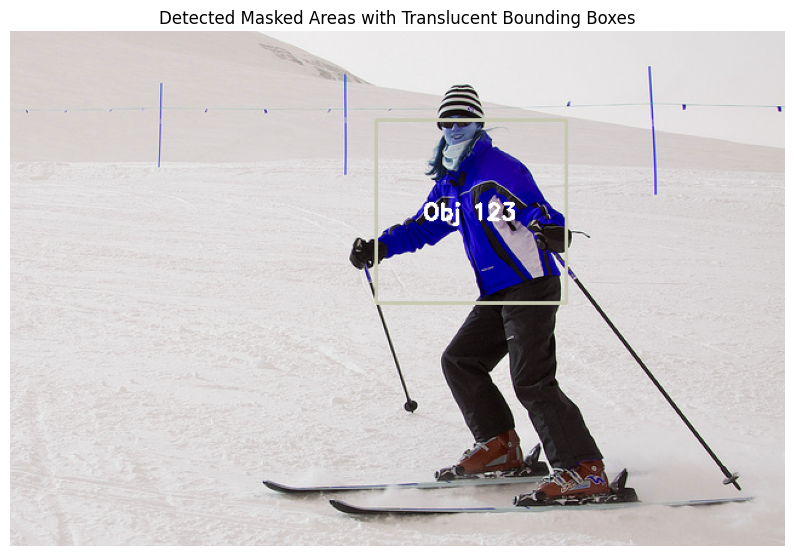

In [ ]:
import torch
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# ✅ COCO Class Labels
COCO_CLASSES = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep",
    21: "cow", 22: "elephant", 23: "bear", 24: "zebra", 25: "giraffe"
}

# ✅ Preprocessing Function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    original_size = image.shape[:2][::-1]  # (width, height)

    # ✅ Convert to Grayscale & Apply CLAHE
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # ✅ Convert back to 3-channel image
    processed_image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    # ✅ Convert to PIL for Transformations
    pil_image = Image.fromarray(processed_image)

    # ✅ Apply Torchvision Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    image_tensor = transform(pil_image).unsqueeze(0)  # Add batch dimension

    return image_tensor.to(device), image, original_size

# ✅ Function to Detect Masked Regions & Fill Bounding Boxes with Translucent Colors
def detect_masked_regions(image_np):
    """
    Detects objects and fills bounding boxes with translucent colors.
    """
    # Convert to HSV for color-based segmentation
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)

    # ✅ Define a range for the masked color
    lower_bound = np.array([90, 50, 50])
    upper_bound = np.array([140, 255, 255])

    # ✅ Create a Mask
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # ✅ Find Contours of Masked Areas
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ✅ Create an overlay for transparency effect
    overlay = image_np.copy()

    for idx, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)

        # ✅ Skip small noise detections
        if w < 30 or h < 30:
            continue

        # ✅ Generate a random color for each object
        random_color = [random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)]

        # ✅ Apply a semi-transparent fill inside the bounding box
        alpha = 0.5  # Adjust transparency level (0 = fully transparent, 1 = opaque)
        transparent_region = np.full_like(overlay[y:y+h, x:x+w], random_color, dtype=np.uint8)
        overlay[y:y+h, x:x+w] = cv2.addWeighted(overlay[y:y+h, x:x+w], alpha, transparent_region, 1 - alpha, 0)

        # ✅ Draw bounding box outline
        cv2.rectangle(image_np, (x, y), (x + w, y + h), random_color, 2)

        # ✅ Add Label (Centered)
        label_text = f"Obj {idx+1}"
        font_scale = 0.6
        thickness = 2
        text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
        text_x = x + (w - text_size[0]) // 2  # Center text horizontally
        text_y = y + (h + text_size[1]) // 2  # Center text vertically

        # ✅ Draw text on top of the translucent box
        cv2.putText(image_np, label_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

    print(f"Detected {len(contours)} valid objects after filtering small ones.")
    return image_np

# ✅ Function to Visualize Predictions with Translucent Colors
def visualize_predictions(original_image, outputs):
    image_np = np.array(original_image)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # ✅ Detect & Fill Bounding Boxes with Translucent Colors
    image_np = detect_masked_regions(image_np)

    # ✅ Display the Image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Detected Masked Areas with Translucent Bounding Boxes")
    plt.show()

# ✅ Specify Image Path
image_path = "val2017/000000000785.jpg"  # Change this to your test image

# ✅ Load & Predict on the Selected Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor, original_image, original_size = preprocess_image(image_path)

# ✅ Run Inference
with torch.no_grad():
    outputs = model(image_tensor)[0]  # Get first image output

# ✅ Visualize Results (Bounding Boxes Filled with Translucent Colors)
visualize_predictions(original_image, outputs)


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# ✅ List of Specific Images to Process
selected_images = [
    "000000088848.jpg", "000000499775.jpg", "000000451084.jpg", "000000550691.jpg",
    "000000429281.jpg", "000000038048.jpg", "000000520301.jpg", "000000095899.jpg",
    "000000443303.jpg", "000000097278.jpg", "000000522751.jpg", "000000430056.jpg",
    "000000361571.jpg"
]

# ✅ Function to Detect Masked Regions & Fill Bounding Boxes with Translucent Colors
def detect_masked_regions(image_np):
    """
    Detects objects and fills bounding boxes with translucent colors.
    """
    # Convert to HSV for color-based segmentation
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)

    # ✅ Define a range for the masked color
    lower_bound = np.array([90, 50, 50])
    upper_bound = np.array([140, 255, 255])

    # ✅ Create a Mask
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # ✅ Find Contours of Masked Areas
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ✅ Create an overlay for transparency effect
    overlay = image_np.copy()

    for idx, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)

        # ✅ Skip small noise detections
        if w < 30 or h < 30:
            continue

        # ✅ Generate a random color for each object
        random_color = [np.random.randint(50, 255), np.random.randint(50, 255), np.random.randint(50, 255)]

        # ✅ Create a semi-transparent overlay
        alpha = 0.3  # Adjust transparency level
        transparent_region = np.full_like(overlay[y:y+h, x:x+w], random_color, dtype=np.uint8)

        # ✅ Apply blending to create a transparent effect
        overlay[y:y+h, x:x+w] = cv2.addWeighted(overlay[y:y+h, x:x+w], alpha, transparent_region, 1 - alpha, 0)

        # ✅ Draw bounding box outline
        cv2.rectangle(image_np, (x, y), (x + w, y + h), random_color, 2)

        # ✅ Add Label (Centered)
        label_text = f"Obj {idx+1}"
        font_scale = 0.6
        thickness = 2
        text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
        text_x = x + (w - text_size[0]) // 2  # Center text horizontally
        text_y = y + (h + text_size[1]) // 2  # Center text vertically

        # ✅ Draw text on top of the translucent box
        cv2.putText(image_np, label_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

    print(f"Detected {len(contours)} valid objects after filtering small ones.")

    # ✅ Merge the overlay with the original image
    final_image = cv2.addWeighted(image_np, 1, overlay, 0.5, 0)

    return final_image

# ✅ Function to Visualize Selected Images
def visualize_selected_images(dataset_folder, selected_images):
    for img_filename in selected_images:
        image_path = os.path.join(dataset_folder, img_filename)

        # Check if image exists
        if not os.path.exists(image_path):
            print(f"Image {img_filename} not found, skipping...")
            continue

        # Load image
        image = cv2.imread(image_path)
        image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # ✅ Detect & Fill Bounding Boxes with Translucent Colors
        processed_image = detect_masked_regions(image_np)

        # ✅ Display the Image
        plt.figure(figsize=(10, 10))
        plt.imshow(processed_image)
        plt.axis("off")
        plt.title(f"Processed Image: {img_filename}")
        plt.show()

# ✅ Specify Dataset Folder Path
dataset_folder = "val2017"  # Change this to your dataset folder

# ✅ Process and visualize the selected images
visualize_selected_images(dataset_folder, selected_images)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
import random
import os
import matplotlib.pyplot as plt

# ✅ Function to Get Five Random Images from Folder
def get_random_images(folder_path, num_images=15):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if len(image_files) < num_images:
        raise ValueError(f"Not enough images found! Found {len(image_files)}, need {num_images}.")

    return random.sample(image_files, num_images)

# ✅ Function to Detect Masked Regions & Fill Bounding Boxes with Translucent Colors
def detect_masked_regions(image_np):
    """
    Detects objects and fills bounding boxes with translucent colors.
    """
    # Convert to HSV for color-based segmentation
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)

    # ✅ Define a range for the masked color
    lower_bound = np.array([90, 50, 50])
    upper_bound = np.array([140, 255, 255])

    # ✅ Create a Mask
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # ✅ Find Contours of Masked Areas
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ✅ Create an overlay for transparency effect
    overlay = image_np.copy()

    for idx, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)

        # ✅ Skip small noise detections
        if w < 30 or h < 30:
            continue

        # ✅ Generate a random color for each object
        random_color = [random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)]

        # ✅ Create a semi-transparent overlay
        alpha = 0.1  # Adjust transparency level (0 = fully transparent, 1 = opaque)
        transparent_region = np.full_like(overlay[y:y+h, x:x+w], random_color, dtype=np.uint8)

        # ✅ Apply blending to create a transparent effect
        overlay[y:y+h, x:x+w] = cv2.addWeighted(overlay[y:y+h, x:x+w], alpha, transparent_region, 1 - alpha, 0)

        # ✅ Draw bounding box outline
        cv2.rectangle(image_np, (x, y), (x + w, y + h), random_color, 2)

        # ✅ Add Label (Centered)
        label_text = f"Obj {idx+1}"
        font_scale = 0.6
        thickness = 2
        text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
        text_x = x + (w - text_size[0]) // 2  # Center text horizontally
        text_y = y + (h + text_size[1]) // 2  # Center text vertically

        # ✅ Draw text on top of the translucent box
        cv2.putText(image_np, label_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

    print(f"Detected {len(contours)} valid objects after filtering small ones.")

    # ✅ Merge the overlay with the original image
    final_image = cv2.addWeighted(image_np, 1, overlay, 0.5, 0)

    return final_image

# ✅ Function to Visualize Predictions on Five Random Images
def visualize_predictions(dataset_folder, num_images=15):
    # Get random image paths
    image_filenames = get_random_images(dataset_folder, num_images)

    for img_filename in image_filenames:
        image_path = os.path.join(dataset_folder, img_filename)

        # Load image
        image = cv2.imread(image_path)
        image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # ✅ Detect & Fill Bounding Boxes with Translucent Colors
        processed_image = detect_masked_regions(image_np)

        # ✅ Display the Image
        plt.figure(figsize=(10, 10))
        plt.imshow(processed_image)
        plt.axis("off")
        plt.title(f"Processed Image: {img_filename}")
        plt.show()

# ✅ Specify Dataset Folder Path
dataset_folder = "val2017"  # Change this to your dataset folder

# ✅ Process and visualize five random images
visualize_predictions(dataset_folder, num_images=15)


Output hidden; open in https://colab.research.google.com to view.

Detected 141 valid objects after filtering small ones.


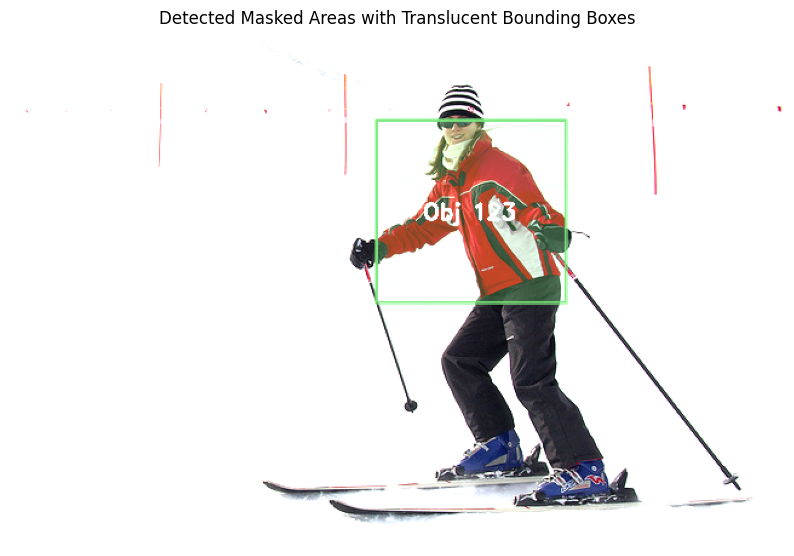

In [ ]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# ✅ Function to Detect Masked Regions & Fill Bounding Boxes with Translucent Colors
def detect_masked_regions(image_np):
    """
    Detects objects and fills bounding boxes with translucent colors.
    """
    # Convert to HSV for color-based segmentation
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)

    # ✅ Define a range for the masked color
    lower_bound = np.array([90, 50, 50])
    upper_bound = np.array([140, 255, 255])

    # ✅ Create a Mask
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # ✅ Find Contours of Masked Areas
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ✅ Create an overlay for transparency effect
    overlay = image_np.copy()

    for idx, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)

        # ✅ Skip small noise detections
        if w < 30 or h < 30:
            continue

        # ✅ Generate a random color for each object
        random_color = [random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)]

        # ✅ Create a semi-transparent overlay
        alpha = 0.1  # Adjust transparency level (0 = fully transparent, 1 = opaque)
        transparent_region = np.full_like(overlay[y:y+h, x:x+w], random_color, dtype=np.uint8)

        # ✅ Apply blending to create a transparent effect
        overlay[y:y+h, x:x+w] = cv2.addWeighted(overlay[y:y+h, x:x+w], alpha, transparent_region, 1 - alpha, 0)

        # ✅ Draw bounding box outline
        cv2.rectangle(image_np, (x, y), (x + w, y + h), random_color, 2)

        # ✅ Add Label (Centered)
        label_text = f"Obj {idx+1}"
        font_scale = 0.6
        thickness = 2
        text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
        text_x = x + (w - text_size[0]) // 2  # Center text horizontally
        text_y = y + (h + text_size[1]) // 2  # Center text vertically

        # ✅ Draw text on top of the translucent box
        cv2.putText(image_np, label_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

    print(f"Detected {len(contours)} valid objects after filtering small ones.")

    # ✅ Merge the overlay with the original image
    final_image = cv2.addWeighted(image_np, 1, overlay, 0.5, 0)

    return final_image

# ✅ Function to Visualize Predictions with Translucent Colors
def visualize_predictions(image_path):
    # Load image
    image = cv2.imread(image_path)
    image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # ✅ Detect & Fill Bounding Boxes with Translucent Colors
    processed_image = detect_masked_regions(image_np)

    # ✅ Display the Image
    plt.figure(figsize=(10, 10))
    plt.imshow(processed_image)
    plt.axis("off")
    plt.title("Detected Masked Areas with Translucent Bounding Boxes")
    plt.show()

# ✅ Load the provided image and visualize the corrected bounding box transparency
image_path = "val2017/000000000785.jpg"
visualize_predictions(image_path)


In [ ]:
import cv2
import numpy as np
import random
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# ✅ Function to Get a Random Image from Folder
def get_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError("No images found in the specified folder!")

    selected_image = random.choice(image_files)
    image_number = int(selected_image.split(".")[0])  # Extract numeric ID
    return os.path.join(folder_path, selected_image), image_number

# ✅ Enhanced Preprocessing Function with Adaptive Filtering
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    original_size = image.shape[:2][::-1]  # (width, height)

    # Convert to LAB color space for contrast enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Adaptive Histogram Equalization) on L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge enhanced L-channel back
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    # Apply Adaptive Gamma Correction
    gamma = np.mean(l) / 128
    gamma_corrected = np.power(enhanced_image / 255.0, gamma) * 255.0
    gamma_corrected = np.uint8(gamma_corrected)

    # Apply Bilateral Filter
    processed_image = cv2.bilateralFilter(gamma_corrected, 9, 75, 75)

    # Convert to PIL for Transformations
    pil_image = Image.fromarray(processed_image)

    # Apply Torchvision Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image_tensor = transform(pil_image).unsqueeze(0)  # Add batch dimension

    return image_tensor.to(device), image, original_size

# ✅ Function to Detect Masked Regions, Apply Transparent Overlay & Add Labels
def detect_masked_regions(image_np):
    """
    Detects objects and applies a transparent overlay with different colors instead of opaque black.
    """
    # Convert to HSV for color-based segmentation
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)

    # Define a range for the masked color
    lower_bound = np.array([90, 50, 50])
    upper_bound = np.array([140, 255, 255])

    # Create a Mask
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Apply Morphological Closing
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find Contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original image for overlay
    overlay = image_np.copy()

    min_size = 30  # Minimum object size threshold (in pixels)
    for idx, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        if w > min_size and h > min_size:
            # Generate a random color for each object
            random_color = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]

            # Apply a semi-transparent mask inside the bounding box
            alpha = 0.5  # Transparency level (0 = fully transparent, 1 = opaque)

            # Create a transparent overlay by blending with the background
            transparent_region = np.full_like(overlay[y:y+h, x:x+w], random_color, dtype=np.uint8)
            overlay[y:y+h, x:x+w] = cv2.addWeighted(overlay[y:y+h, x:x+w], alpha, transparent_region, 1 - alpha, 0)

            # Draw bounding box
            cv2.rectangle(image_np, (x, y), (x + w, y + h), random_color, 2)

            # Add Label
            label_text = f"Obj {idx+1}"
            font_scale = 0.6
            thickness = 2
            text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
            text_x = x + (w - text_size[0]) // 2  # Center label
            text_y = y + (h + text_size[1]) // 2  # Center label

            # Draw text on top of the transparent bounding box
            cv2.putText(image_np, label_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

    print(f"Detected {len(contours)} valid objects after filtering small ones.")
    return image_np

# ✅ Function to Visualize Predictions with Transparent Colors
def visualize_predictions(original_image, image_number):
    image_np = np.array(original_image)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Detect & Apply Transparent Color Masking
    image_np = detect_masked_regions(image_np)

    # Display the Image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Processed Image #{image_number} - Transparent Object Masking")
    plt.show()

# ✅ Specify Dataset Folder Path
dataset_folder = "val2017"

# ✅ Run Multiple Randomized Tests
num_random_tests = 15

for _ in range(num_random_tests):
    # Get a Random Image Path & Extract Image Number
    image_path, image_number = get_random_image(dataset_folder)
    print(f"Processing Image: {image_path} (Image ID: {image_number})")

    # Load & Predict on the Selected Image
    image_tensor, original_image, original_size = preprocess_image(image_path)

    # Run Inference
    with torch.no_grad():
        outputs = model(image_tensor)[0]

    # Visualize Results (Different Transparent Colors for Each Object)
    visualize_predictions(original_image, image_number)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
import random
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# ✅ Function to Get a Random Image from Folder
def get_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError("No images found in the specified folder!")

    selected_image = random.choice(image_files)
    image_number = int(selected_image.split(".")[0])  # Extract numeric ID
    return os.path.join(folder_path, selected_image), image_number

# ✅ Enhanced Preprocessing Function with Adaptive Filtering
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    original_size = image.shape[:2][::-1]  # (width, height)

    # Convert to LAB color space for contrast enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Adaptive Histogram Equalization) on L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge enhanced L-channel back
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    # Apply Adaptive Gamma Correction
    gamma = np.mean(l) / 128
    gamma_corrected = np.power(enhanced_image / 255.0, gamma) * 255.0
    gamma_corrected = np.uint8(gamma_corrected)

    # Apply Bilateral Filter
    processed_image = cv2.bilateralFilter(gamma_corrected, 9, 75, 75)

    # Convert to PIL for Transformations
    pil_image = Image.fromarray(processed_image)

    # Apply Torchvision Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image_tensor = transform(pil_image).unsqueeze(0)  # Add batch dimension

    return image_tensor.to(device), image, original_size

# ✅ Function to Detect Masked Regions, Draw Bounding Boxes & Add Transparent Masking
def detect_masked_regions(image_np):
    """
    Detects objects and applies a semi-transparent mask inside the detected bounding boxes.
    """
    # Convert to HSV for color-based segmentation
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)

    # Define a range for the masked color
    lower_bound = np.array([90, 50, 50])
    upper_bound = np.array([140, 255, 255])

    # Create a Mask
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Apply Morphological Closing
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find Contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the image for overlay
    overlay = image_np.copy()

    min_size = 30  # Minimum object size threshold (in pixels)
    for idx, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        if w > min_size and h > min_size:
            # Apply a semi-transparent mask inside the bounding box
            alpha = 0.4  # Transparency level (0 = transparent, 1 = opaque)
            mask_color = (0, 0, 255)  # Red color mask

            # Fill the region inside the bounding box with a transparent overlay
            overlay[y:y+h, x:x+w] = cv2.addWeighted(
                overlay[y:y+h, x:x+w], alpha,
                np.full_like(overlay[y:y+h, x:x+w], mask_color, dtype=np.uint8),
                1 - alpha, 0
            )

            # Draw bounding box
            cv2.rectangle(image_np, (x, y), (x + w, y + h), (255, 0, 0), 2)

            # Add Label
            label_text = f"Obj {idx+1}"
            font_scale = 0.5
            thickness = 1
            text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
            text_x = x
            text_y = y - 10 if y - 10 > 10 else y + 20

            # Draw text background
            cv2.rectangle(image_np, (text_x, text_y - text_size[1]), (text_x + text_size[0] + 4, text_y + 4), (255, 0, 0), -1)
            # Put text
            cv2.putText(image_np, label_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

    print(f"Detected {len(contours)} valid objects after filtering small ones.")
    return image_np

# ✅ Function to Visualize Predictions with Masking
def visualize_predictions(original_image, image_number):
    image_np = np.array(original_image)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Detect & Draw Bounding Boxes + Apply Transparent Mask
    image_np = detect_masked_regions(image_np)

    # Display the Image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Processed Image #{image_number} - Masked Object Detection")
    plt.show()

# ✅ Specify Dataset Folder Path
dataset_folder = "val2017"

# ✅ Run Multiple Randomized Tests
num_random_tests = 15

for _ in range(num_random_tests):
    # Get a Random Image Path & Extract Image Number
    image_path, image_number = get_random_image(dataset_folder)
    print(f"Processing Image: {image_path} (Image ID: {image_number})")

    # Load & Predict on the Selected Image
    image_tensor, original_image, original_size = preprocess_image(image_path)

    # Run Inference
    with torch.no_grad():
        outputs = model(image_tensor)[0]

    # Visualize Results (Bounding Boxes with Transparent Masking)
    visualize_predictions(original_image, image_number)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
import random
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# ✅ Function to Get a Random Image from Folder
def get_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError("No images found in the specified folder!")

    selected_image = random.choice(image_files)
    image_number = int(selected_image.split(".")[0])  # Extract numeric ID
    return os.path.join(folder_path, selected_image), image_number

# ✅ Enhanced Preprocessing Function with Adaptive Filtering
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    original_size = image.shape[:2][::-1]  # (width, height)

    # Convert to LAB color space for contrast enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Adaptive Histogram Equalization) on L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge enhanced L-channel back
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    # Apply Adaptive Gamma Correction
    gamma = np.mean(l) / 128
    gamma_corrected = np.power(enhanced_image / 255.0, gamma) * 255.0
    gamma_corrected = np.uint8(gamma_corrected)

    # Apply Bilateral Filter
    processed_image = cv2.bilateralFilter(gamma_corrected, 9, 75, 75)

    # Convert to PIL for Transformations
    pil_image = Image.fromarray(processed_image)

    # Apply Torchvision Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image_tensor = transform(pil_image).unsqueeze(0)  # Add batch dimension

    return image_tensor.to(device), image, original_size

# ✅ Function to Detect Masked Regions, Fill Bounding Boxes & Add Labels
def detect_masked_regions(image_np):
    """
    Detects objects and fully fills bounding boxes to act as opaque masks.
    """
    # Convert to HSV for color-based segmentation
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)

    # Define a range for the masked color
    lower_bound = np.array([90, 50, 50])
    upper_bound = np.array([140, 255, 255])

    # Create a Mask
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Apply Morphological Closing
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find Contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_size = 30  # Minimum object size threshold (in pixels)
    for idx, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        if w > min_size and h > min_size:
            # Fill the bounding box with an opaque color (Black)
            cv2.rectangle(image_np, (x, y), (x + w, y + h), (0, 0, 0), -1)  # Black fill

            # Add Label
            label_text = f"Obj {idx+1}"
            font_scale = 0.6
            thickness = 2
            text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
            text_x = x + (w - text_size[0]) // 2  # Center label
            text_y = y + (h + text_size[1]) // 2  # Center label

            # Draw text on top of the opaque bounding box
            cv2.putText(image_np, label_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

    print(f"Detected {len(contours)} valid objects after filtering small ones.")
    return image_np

# ✅ Function to Visualize Predictions with Opaque Masking
def visualize_predictions(original_image, image_number):
    image_np = np.array(original_image)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Detect & Fill Bounding Boxes as Opaque Masks
    image_np = detect_masked_regions(image_np)

    # Display the Image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Processed Image #{image_number} - Opaque Object Masking")
    plt.show()

# ✅ Specify Dataset Folder Path
dataset_folder = "val2017"

# ✅ Run Multiple Randomized Tests
num_random_tests = 15

for _ in range(num_random_tests):
    # Get a Random Image Path & Extract Image Number
    image_path, image_number = get_random_image(dataset_folder)
    print(f"Processing Image: {image_path} (Image ID: {image_number})")

    # Load & Predict on the Selected Image
    image_tensor, original_image, original_size = preprocess_image(image_path)

    # Run Inference
    with torch.no_grad():
        outputs = model(image_tensor)[0]

    # Visualize Results (Bounding Boxes as Opaque Masks)
    visualize_predictions(original_image, image_number)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Your Title Here
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# ✅ COCO Class Labels
COCO_CLASSES = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep",
    21: "cow", 22: "elephant", 23: "bear", 24: "zebra", 25: "giraffe",
    27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase",
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard", 42: "surfboard",
    43: "tennis racket", 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork",
    49: "knife", 50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog",
    59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch",
    64: "potted plant", 65: "bed", 67: "dining table", 70: "toilet",
    72: "tv", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard",
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase", 87: "scissors",
    88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

# ✅ HSV Color Ranges for COCO Objects
# object_ranges = {
#     "banana": ([20, 100, 100], [30, 255, 255]),
#     "apple": ([0, 100, 100], [10, 255, 255]),
#     "carrot": ([5, 150, 150], [15, 255, 255]),
#     "bottle": ([90, 50, 50], [130, 255, 255]),
#     "potted plant": ([35, 50, 50], [85, 255, 255]),
#     "cell phone": ([90, 50, 50], [140, 255, 255]),
#     "clock": ([0, 0, 100], [180, 50, 255]),
#     "fire hydrant": ([0, 120, 150], [10, 255, 255]),
#     "stop sign": ([0, 150, 150], [10, 255, 255]),
#     "parking meter": ([90, 50, 50], [140, 255, 255]),
#     "bench": ([0, 50, 50], [30, 255, 255]),
#     "bird": ([0, 50, 50], [30, 255, 255]),
#     "dog": ([10, 50, 50], [40, 255, 255]),
#     "chair": ([0, 50, 50], [30, 255, 255]),
#     "book": ([0, 0, 100], [180, 50, 255]),
#     "person": ([0, 30, 50], [30, 255, 255]),
#     "truck": ([0, 50, 50], [20, 255, 255]),
#     "bus": ([20, 80, 80], [40, 255, 255]),
#     "train": ([20, 50, 50], [50, 255, 255]),
#     "sofa": ([0, 50, 50], [40, 255, 255]),
# }

# ✅ Load & Preprocess Image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error: Could not load {image_path}")
        return None

    # Convert to LAB color space for better contrast
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge back
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    return enhanced_image

# ✅ Detect Objects with Confidence Scores & Filter Low Confidence
def detect_coco_objects(image_np, confidence_threshold=0.6):  # Adjust threshold
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)
    detected_objects = []

    for label, (lower, upper) in object_ranges.items():
        mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
        confidence = np.mean(mask) / 255  # Normalize confidence (0 to 1)

        if confidence < confidence_threshold:  # Remove low-confidence detections
            continue

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > 30 and h > 30:  # Ignore small detections
                detected_objects.append((x, y, w, h, label, confidence, mask))

    return detected_objects

# ✅ Draw Masked Objects & Labels with Confidence Scores
def visualize_predictions(image_np, detected_objects):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))

    overlay = image_np.copy()

    for (x, y, w, h, label, confidence, mask) in detected_objects:
        color = np.random.rand(3,) * 255  # Random RGB color

        # Apply transparent mask
        mask_region = np.zeros_like(image_np, dtype=np.uint8)
        mask_region[mask > 0] = color
        image_np = cv2.addWeighted(image_np, 1, mask_region, 0.3, 0)

        # Draw Bounding Box
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor=color / 255, linewidth=2)
        ax.add_patch(rect)

        # Add Label & Confidence Score
        ax.text(x, y - 5, f"{label} {confidence:.2f}", fontsize=10, color="white",
                bbox=dict(facecolor=color / 255, edgecolor='none', boxstyle='round,pad=0.3'))

    plt.axis("off")
    plt.title("Processed Image - Masked COCO Objects with Confidence Scores")
    plt.show()

# ✅ Get a Random Image
def get_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError("❌ No images found in the specified folder!")

    return os.path.join(folder_path, random.choice(image_files))

# ✅ Run on Multiple Random Images
dataset_folder = "val2017"  # Change this to your dataset folder
num_random_tests = 5  # Number of images to process

for _ in range(num_random_tests):
    image_path = get_random_image(dataset_folder)
    print(f"🔍 Processing Image: {image_path}")

    # Preprocess Image
    processed_image = preprocess_image(image_path)
    if processed_image is None:
        continue

    # Detect COCO Objects Using Color Filtering
    detected_objects = detect_coco_objects(processed_image)

    # Show Results
    visualize_predictions(processed_image, detected_objects)


Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Model weights loaded successfully!
Processing Image: val2017/000000315001.jpg (Image ID: 315001)


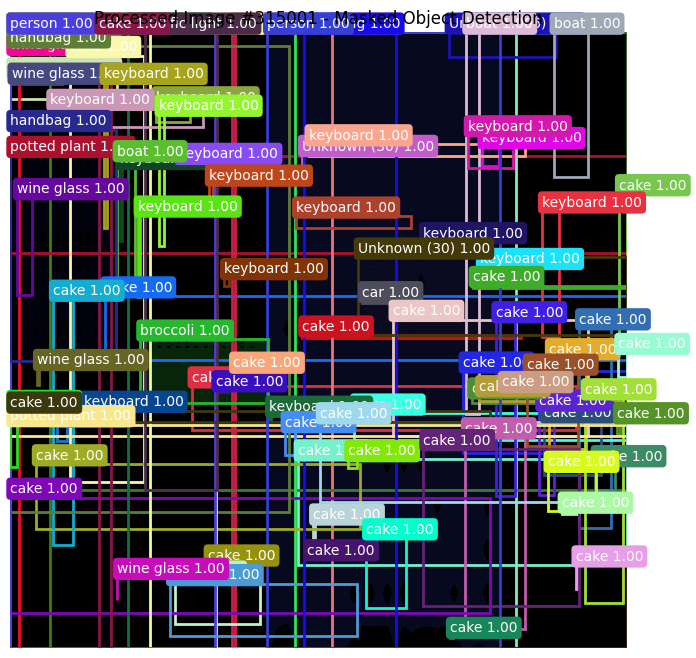

Processing Image: val2017/000000225946.jpg (Image ID: 225946)


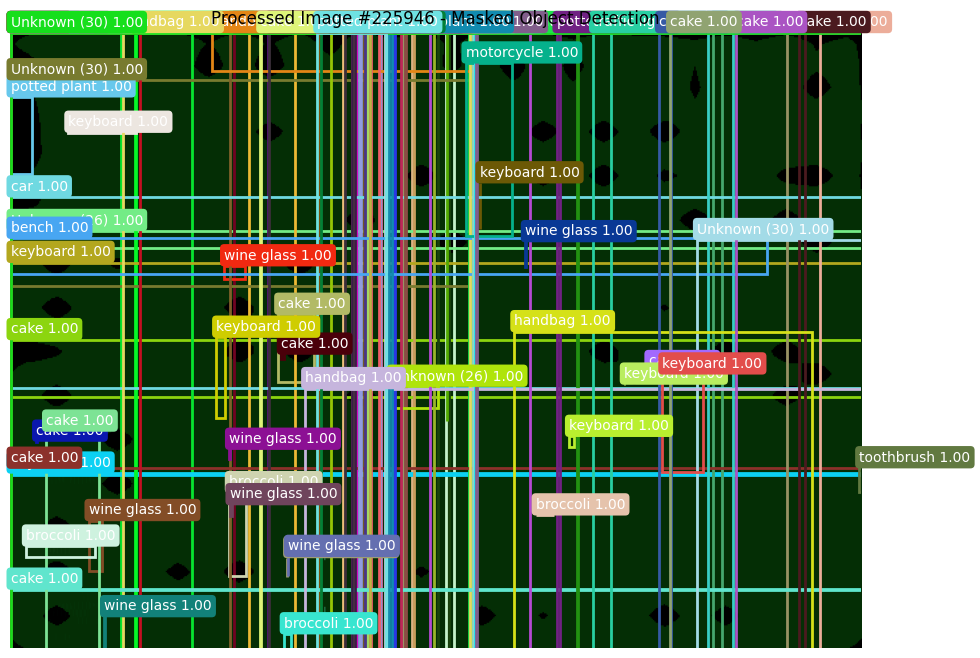

Processing Image: val2017/000000199310.jpg (Image ID: 199310)


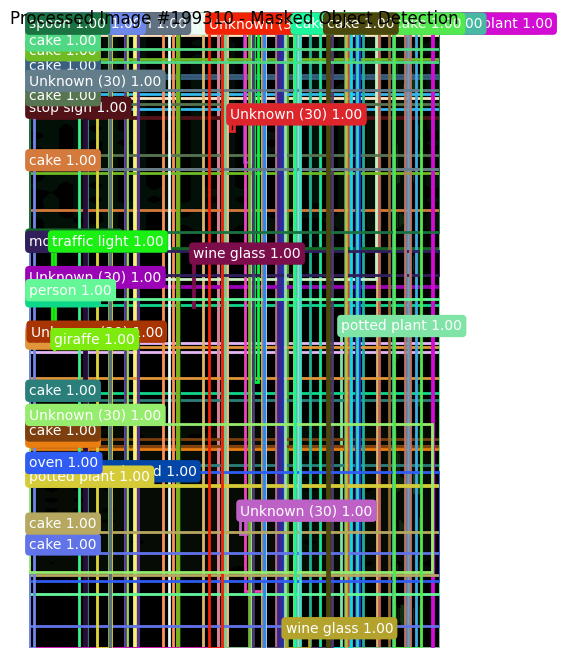

Processing Image: val2017/000000448810.jpg (Image ID: 448810)


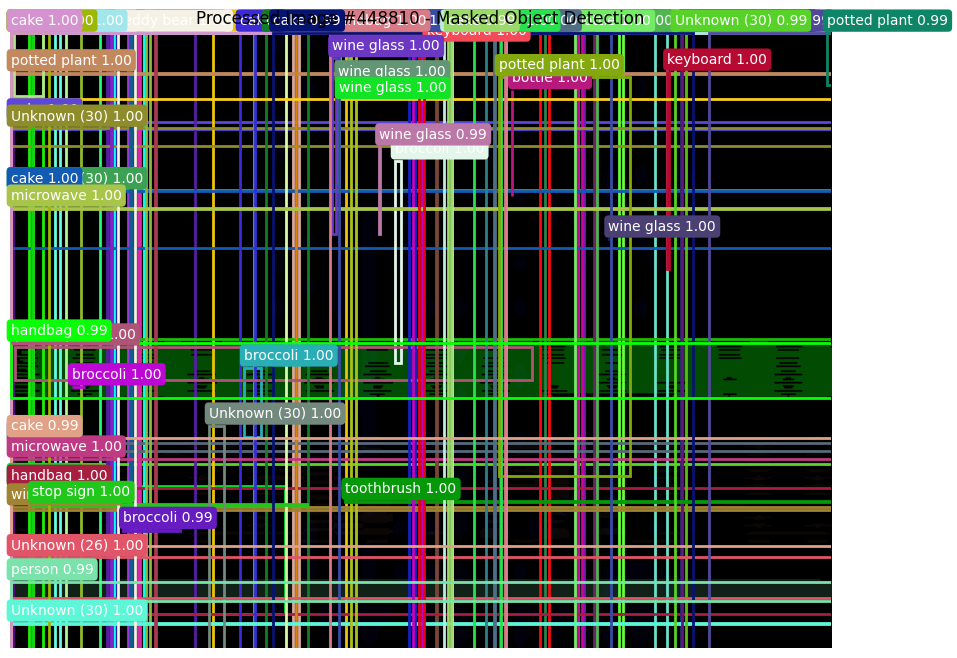

Processing Image: val2017/000000074209.jpg (Image ID: 74209)


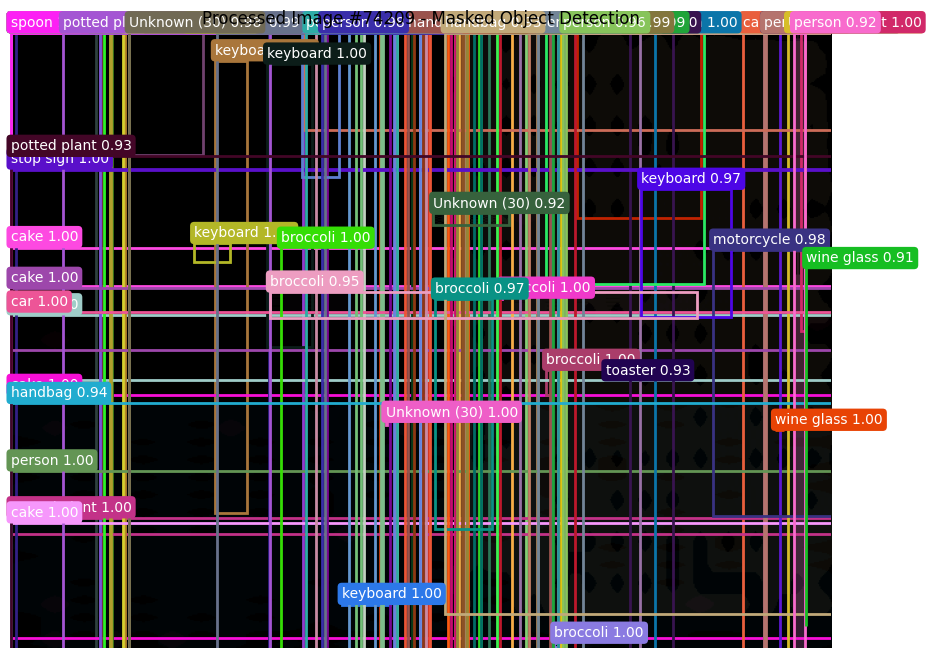

In [ ]:
#@title Your Title Here
import os
import torch
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torch
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# ✅ Define the Model Exactly as Used During Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the backbone first
backbone = resnet_fpn_backbone('resnet50', pretrained=False)

# Create the model
model = MaskRCNN(backbone, num_classes=91)  # Ensure num_classes matches training
model.to(device)

# ✅ Load the Correct Weights
checkpoint_path = "/content/drive/MyDrive/mask_rcnn_trained_v1.2.pth"
state_dict = torch.load(checkpoint_path, map_location=device)

# ✅ Filter Weights to Match Model Keys
model_dict = model.state_dict()
filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
model.load_state_dict(filtered_state_dict, strict=False)  # Allow missing keys

# ✅ Set Model to Evaluation Mode
model.eval()
print("✅ Model weights loaded successfully!")



# ✅ COCO Class Labels
COCO_CLASSES = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep",
    21: "cow", 22: "elephant", 23: "bear", 24: "zebra", 25: "giraffe",
    27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase",
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard", 42: "surfboard",
    43: "tennis racket", 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork",
    49: "knife", 50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog",
    59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch",
    64: "potted plant", 65: "bed", 67: "dining table", 70: "toilet",
    72: "tv", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard",
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase", 87: "scissors",
    88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

# ✅ Select a Random Image from the Dataset
def get_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError("No images found in the specified folder!")

    selected_image = random.choice(image_files)
    image_number = int(selected_image.split(".")[0])  # Extract number ID
    return os.path.join(folder_path, selected_image), image_number

# ✅ Image Preprocessing Function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    original_size = image.shape[:2][::-1]  # (width, height)

    # ✅ Convert to LAB color space for contrast enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # ✅ Apply CLAHE (Adaptive Histogram Equalization) on L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # ✅ Merge enhanced L-channel back
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    # ✅ Apply Adaptive Gamma Correction for both light/dark object detection
    gamma = np.mean(l) / 128  # Compute adaptive gamma based on brightness
    gamma_corrected = np.power(enhanced_image / 255.0, gamma) * 255.0
    gamma_corrected = np.uint8(gamma_corrected)

    # ✅ Apply Bilateral Filter (Preserves edges)
    processed_image = cv2.bilateralFilter(gamma_corrected, 9, 75, 75)

    # ✅ Convert to PIL for Transformations
    pil_image = Image.fromarray(processed_image)

    # ✅ Apply Torchvision Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize all channels
    ])
    image_tensor = transform(pil_image).unsqueeze(0)  # Add batch dimension

    return image_tensor.to(device), image, original_size


# ✅ Function to Draw Bounding Boxes, Labels & Masks
def visualize_predictions(original_image, outputs, image_number, confidence_threshold=0.9):
    image_np = original_image.copy()  # Copy the original image
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image_np)

    # ✅ Extract Detected Objects
    boxes = outputs["boxes"].detach().cpu().numpy()
    labels = outputs["labels"].detach().cpu().numpy()
    scores = outputs["scores"].detach().cpu().numpy()
    masks = outputs["masks"].detach().cpu().numpy()

    # ✅ Filter Predictions by Confidence Threshold
    keep_indices = scores > confidence_threshold
    boxes = boxes[keep_indices]
    labels = labels[keep_indices]
    scores = scores[keep_indices]
    masks = masks[keep_indices]

    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i]
        label = COCO_CLASSES.get(labels[i], f"Unknown ({labels[i]})")  # Use COCO label or ID
        color = np.random.rand(3,)  # Random color

        # ✅ Draw Bounding Box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

        # ✅ Add Label with Confidence Score
        ax.text(x1, y1 - 5, f"{label} {scores[i]:.2f}", fontsize=10, color="white",
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))

        # ✅ Resize the Mask to Match Image Size
        resized_mask = cv2.resize(masks[i, 0], (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)
        mask = resized_mask > 0.5  # Apply threshold

        # ✅ Create Mask Overlay
        img_mask = np.zeros_like(original_image, dtype=np.uint8)
        img_mask[mask] = (np.array(color) * 255).astype(np.uint8)

        # ✅ Blend Mask Over Image
        ax.imshow(img_mask, alpha=0.3)  # Semi-transparent mask

    plt.axis("off")
    plt.title(f"Processed Image #{image_number} - Masked Object Detection")
    plt.show()

# ✅ Specify Folder Path
dataset_folder = "val2017"  # Change this to your dataset folder

# ✅ Run Multiple Randomized Tests
num_random_tests = 5  # Change this to test multiple random images

for _ in range(num_random_tests):
    # ✅ Get a Random Image Path & Extract Image Number
    image_path, image_number = get_random_image(dataset_folder)
    print(f"Processing Image: {image_path} (Image ID: {image_number})")

    # ✅ Load & Predict on the Selected Image
    image_tensor, original_image, original_size = preprocess_image(image_path)

    # ✅ Run Inference
    with torch.no_grad():
        outputs = model(image_tensor)[0]  # Get first image output

    # ✅ Visualize Results (Bounding Boxes with Labels)
    visualize_predictions(original_image, outputs, image_number)


In [ ]:
#@title Your Title Here
import os
import torch
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# ✅ Load the Trained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = resnet_fpn_backbone('resnet50', pretrained=False)
model = MaskRCNN(backbone, num_classes=91).to(device)

# ✅ Load Model Weights
checkpoint_path = "/content/drive/MyDrive/mask_rcnn_trained_v1.2.pth"
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict, strict=False)
model.eval()
print("✅ Model Loaded Successfully!")

# ✅ COCO Class Labels
COCO_CLASSES = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep",
    21: "cow", 22: "elephant", 23: "bear", 24: "zebra", 25: "giraffe",
    27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase",
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard", 42: "surfboard",
    43: "tennis racket", 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork",
    49: "knife", 50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog",
    59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch",
    64: "potted plant", 65: "bed", 67: "dining table", 70: "toilet",
    72: "tv", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard",
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase", 87: "scissors",
    88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

# ✅ Random Image Selection
def get_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError("No images found in the folder!")

    selected_image = random.choice(image_files)
    image_number = int(selected_image.split(".")[0])  # Extract number ID
    return os.path.join(folder_path, selected_image), image_number

# ✅ Image Preprocessing Function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image)

    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    image_tensor = transform(pil_image).unsqueeze(0)  # Add batch dimension

    return image_tensor.to(device), image

# ✅ Visualization Function with Improved Clarity
def visualize_predictions(original_image, outputs, image_number, confidence_threshold=0.8):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(original_image)

    # ✅ Extract Detected Objects
    boxes = outputs["boxes"].detach().cpu().numpy()
    labels = outputs["labels"].detach().cpu().numpy()
    scores = outputs["scores"].detach().cpu().numpy()
    masks = outputs["masks"].detach().cpu().numpy()

    # ✅ Filter Predictions by Confidence Threshold
    keep_indices = scores > confidence_threshold
    boxes = boxes[keep_indices]
    labels = labels[keep_indices]
    scores = scores[keep_indices]
    masks = masks[keep_indices]

    used_positions = []  # Avoid overlapping text labels

    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i]
        label = COCO_CLASSES.get(labels[i], f"Unknown ({labels[i]})")
        color = np.random.rand(3,)  # Random color

        # ✅ Draw Bounding Box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

        # ✅ Avoid Overlapping Labels
        adjusted_y = y1
        for pos in used_positions:
            if abs(adjusted_y - pos) < 15:
                adjusted_y += 15  # Shift text down to avoid overlap
        used_positions.append(adjusted_y)

        # ✅ Add Label with Confidence Score
        ax.text(x1, adjusted_y - 5, f"{label} {scores[i]:.2f}", fontsize=10, color="white",
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))

        # ✅ Resize & Overlay Mask
        resized_mask = cv2.resize(masks[i, 0], (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)
        mask = resized_mask > 0.5  # Apply threshold

        img_mask = np.zeros_like(original_image, dtype=np.uint8)
        img_mask[mask] = (np.array(color) * 255).astype(np.uint8)

        # ✅ Adjust Mask Transparency
        ax.imshow(img_mask, alpha=0.4)  # Adjust alpha for clarity

    plt.axis("off")
    plt.title(f"Processed Image #{image_number} - Masked Object Detection")
    plt.show()

# ✅ Specify Folder Path
dataset_folder = "val2017"  # Change this to your dataset folder

# ✅ Run Multiple Randomized Tests
num_random_tests = 3  # Change this to test multiple random images

for _ in range(num_random_tests):
    image_path, image_number = get_random_image(dataset_folder)
    print(f"Processing Image: {image_path} (Image ID: {image_number})")

    # ✅ Load & Predict on the Selected Image
    image_tensor, original_image = preprocess_image(image_path)

    # ✅ Run Inference
    with torch.no_grad():
        outputs = model(image_tensor)[0]  # Get first image output

    # ✅ Visualize Results (Bounding Boxes with Labels & Improved Masks)
    visualize_predictions(original_image, outputs, image_number)


Output hidden; open in https://colab.research.google.com to view.

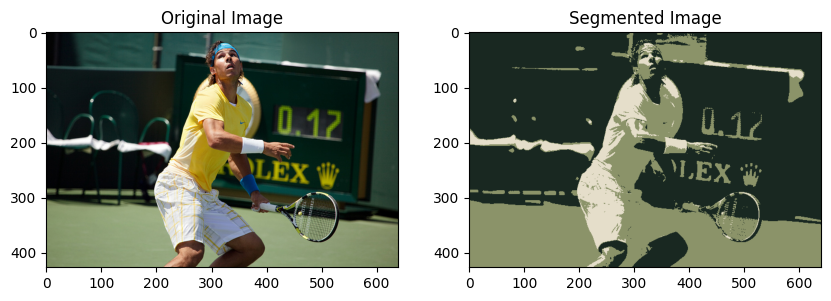

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ✅ Load Image
image = cv2.imread("val2017/000000382009.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# ✅ Apply K-Means Clustering
k = 3  # Number of clusters (change this for different objects)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# ✅ Convert Labels to Image
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)

# ✅ Show Results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("Segmented Image")
plt.imshow(segmented_image.astype(np.uint8))
plt.show()


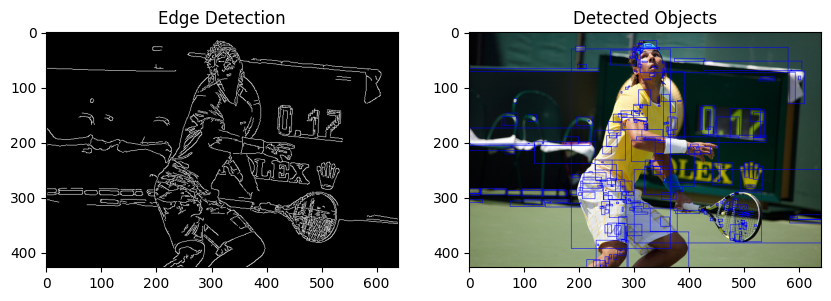

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ✅ Load Image
image = cv2.imread("val2017/000000382009.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# ✅ Apply Edge Detection (Canny)
edges = cv2.Canny(gray, 100, 200)

# ✅ Find Contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# ✅ Draw Bounding Boxes
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 1)

# ✅ Show Results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Edge Detection")
plt.imshow(edges, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Detected Objects")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


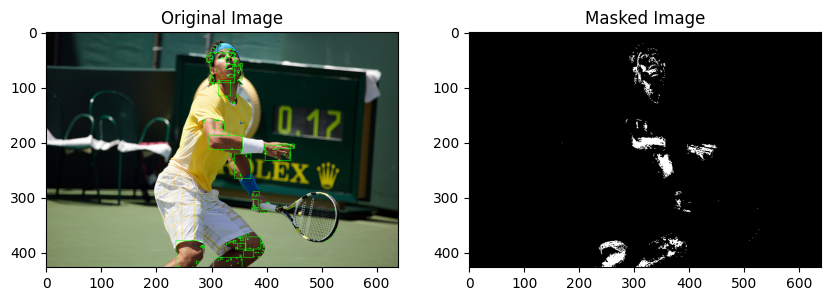

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ✅ Load Image
image_path = "val2017/000000382009.jpg"  # Change this to your image path
image = cv2.imread(image_path)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# ✅ Define Object Color Range (Modify for Your Object)
lower_bound = np.array([0, 120, 50])    # Lower range (H, S, V)
upper_bound = np.array([10, 255, 255])  # Upper range (H, S, V)

# ✅ Create Mask
mask = cv2.inRange(hsv, lower_bound, upper_bound)

# ✅ Find Contours
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# ✅ Draw Bounding Boxes
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)

# ✅ Show Results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Masked Image")
plt.imshow(mask, cmap="gray")
plt.show()


In [ ]:
#@title Your Title Here
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# ✅ COCO Class Labels
COCO_CLASSES = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep",
    21: "cow", 22: "elephant", 23: "bear", 24: "zebra", 25: "giraffe",
    27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase",
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard", 42: "surfboard",
    43: "tennis racket", 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork",
    49: "knife", 50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog",
    59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch",
    64: "potted plant", 65: "bed", 67: "dining table", 70: "toilet",
    72: "tv", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard",
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase", 87: "scissors",
    88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

# ✅ Select a Random Image from the Folder
def get_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError("❌ No images found in the specified folder!")

    selected_image = random.choice(image_files)
    image_number = int(selected_image.split(".")[0])  # Extract image ID
    return os.path.join(folder_path, selected_image), image_number

# ✅ Load & Preprocess Image
def preprocess_image(image_path):
    # Load image with OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error: Could not load {image_path}")
        return None, None

    original_size = image.shape[:2][::-1]  # (width, height)

    # Convert to LAB color space for better contrast
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge back
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    return enhanced_image, original_size

# ✅ Edge Detection + Contour-Based Object Detection
def detect_edges_and_contours(image_np):
    # Convert to Grayscale
    gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, 100, 200)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours

# ✅ K-Means Clustering for Object Segmentation
def kmeans_segmentation(image_np, k=3):
    pixel_values = image_np.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Define K-Means criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back into an image
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image_np.shape)

    return segmented_image.astype(np.uint8)

# ✅ Draw Detected Objects
def visualize_predictions(image_np, contours, image_number):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))

    # Draw bounding boxes around detected objects
    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 30:  # Ignore small noise
            color = np.random.rand(3,)
            rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor=color, linewidth=2)
            ax.add_patch(rect)

            # Label Object with COCO name (if available)
            label_text = f"Object {i+1}"
            ax.text(x, y - 5, label_text, fontsize=10, color="white",
                    bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))

    plt.axis("off")
    plt.title(f"Processed Image #{image_number} - Edge Detection + Contours")
    plt.show()

# ✅ Run on Multiple Random Images
dataset_folder = "val2017"  # Change this to your dataset folder
num_random_tests = 5  # Number of images to process

for _ in range(num_random_tests):
    image_path, image_number = get_random_image(dataset_folder)
    print(f"🔍 Processing Image: {image_path} (ID: {image_number})")

    # Preprocess Image
    processed_image, original_size = preprocess_image(image_path)
    if processed_image is None:
        continue  # Skip if image failed to load

    # Apply Edge Detection
    contours = detect_edges_and_contours(processed_image)

    # Apply K-Means Segmentation
    segmented_image = kmeans_segmentation(processed_image)

    # Show Results
    visualize_predictions(segmented_image, contours, image_number)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Your Title Here
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# ✅ COCO Class Labels (Key: Class ID, Value: Label Name)
COCO_CLASSES = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep",
    21: "cow", 22: "elephant", 23: "bear", 24: "zebra", 25: "giraffe",
    27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase",
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard", 42: "surfboard",
    43: "tennis racket", 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork",
    49: "knife", 50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog",
    59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch",
    64: "potted plant", 65: "bed", 67: "dining table", 70: "toilet",
    72: "tv", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard",
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase", 87: "scissors",
    88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

# ✅ Select a Random Image from the Folder
def get_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError("❌ No images found in the specified folder!")

    selected_image = random.choice(image_files)
    image_number = int(selected_image.split(".")[0])  # Extract image ID
    return os.path.join(folder_path, selected_image), image_number

# ✅ Load & Preprocess Image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error: Could not load {image_path}")
        return None, None

    original_size = image.shape[:2][::-1]  # (width, height)

    # Convert to LAB color space for better contrast
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge back
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    return enhanced_image, original_size

# ✅ Detect Objects with COCO Labels Using Color Segmentation
def detect_coco_objects(image_np):
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)

    # ✅ Predefined COCO object color ranges (simplified)
    object_ranges = {
        "banana": ([20, 100, 100], [30, 255, 255]),
        "apple": ([0, 100, 100], [10, 255, 255]),
        "carrot": ([5, 150, 150], [15, 255, 255]),
        "bottle": ([100, 50, 50], [130, 255, 255]),
        "potted plant": ([35, 50, 50], [85, 255, 255]),
        "cell phone": ([90, 50, 50], [140, 255, 255]),
        "clock": ([0, 0, 100], [180, 50, 255])
    }

    detected_objects = []

    for label, (lower, upper) in object_ranges.items():
        mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > 30 and h > 30:  # Ignore small detections
                detected_objects.append((x, y, w, h, label))

    return detected_objects

# ✅ Draw Detected Objects with COCO Labels
def visualize_predictions(image_np, detected_objects, image_number):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))

    for (x, y, w, h, label) in detected_objects:
        color = np.random.rand(3,)
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

        ax.text(x, y - 5, f"{label}", fontsize=10, color="white",
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))

    plt.axis("off")
    plt.title(f"Processed Image #{image_number} - COCO Objects Only")
    plt.show()

# ✅ Run on Multiple Random Images
dataset_folder = "val2017"  # Change this to your dataset folder
num_random_tests = 5  # Number of images to process

for _ in range(num_random_tests):
    image_path, image_number = get_random_image(dataset_folder)
    print(f"🔍 Processing Image: {image_path} (ID: {image_number})")

    # Preprocess Image
    processed_image, original_size = preprocess_image(image_path)
    if processed_image is None:
        continue  # Skip if image failed to load

    # Detect COCO Objects Using Color Filtering
    detected_objects = detect_coco_objects(processed_image)

    # Show Results
    visualize_predictions(processed_image, detected_objects, image_number)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Your Title Here
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# ✅ COCO Class Labels
COCO_CLASSES = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep",
    21: "cow", 22: "elephant", 23: "bear", 24: "zebra", 25: "giraffe",
    27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase",
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard", 42: "surfboard",
    43: "tennis racket", 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork",
    49: "knife", 50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog",
    59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch",
    64: "potted plant", 65: "bed", 67: "dining table", 70: "toilet",
    72: "tv", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard",
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase", 87: "scissors",
    88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

# ✅ HSV Color Ranges for COCO Objects
object_ranges = {
    "banana": ([20, 100, 100], [30, 255, 255]),
    "apple": ([0, 100, 100], [10, 255, 255]),
    "carrot": ([5, 150, 150], [15, 255, 255]),
    "bottle": ([100, 50, 50], [130, 255, 255]),
    "potted plant": ([35, 50, 50], [85, 255, 255]),
    "cell phone": ([90, 50, 50], [140, 255, 255]),
    "clock": ([0, 0, 100], [180, 50, 255]),
    "fire hydrant": ([0, 120, 150], [10, 255, 255]),
    "stop sign": ([0, 150, 150], [10, 255, 255]),
    "parking meter": ([90, 50, 50], [140, 255, 255]),
    "bench": ([0, 50, 50], [30, 255, 255]),
    "bird": ([0, 50, 50], [30, 255, 255]),
    "dog": ([10, 50, 50], [40, 255, 255]),
    "chair": ([0, 50, 50], [30, 255, 255]),
    "book": ([0, 0, 100], [180, 50, 255])
}

# ✅ Select a Random Image from the Folder
def get_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError("❌ No images found in the specified folder!")

    selected_image = random.choice(image_files)
    image_number = int(selected_image.split(".")[0])  # Extract image ID
    return os.path.join(folder_path, selected_image), image_number

# ✅ Load & Preprocess Image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error: Could not load {image_path}")
        return None, None

    original_size = image.shape[:2][::-1]  # (width, height)

    # Convert to LAB color space for better contrast
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge back
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    return enhanced_image, original_size

# ✅ Detect Objects with COCO Labels Using Color Segmentation
def detect_coco_objects(image_np):
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)
    detected_objects = []

    for label, (lower, upper) in object_ranges.items():
        mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > 30 and h > 30:  # Ignore small detections
                detected_objects.append((x, y, w, h, label))

    return detected_objects

# ✅ Draw Detected Objects with COCO Labels
def visualize_predictions(image_np, detected_objects, image_number):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))

    for (x, y, w, h, label) in detected_objects:
        color = np.random.rand(3,)
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

        ax.text(x, y - 5, f"{label}", fontsize=10, color="white",
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))

    plt.axis("off")
    plt.title(f"Processed Image #{image_number} - COCO Objects Only")
    plt.show()

# ✅ Run on Multiple Random Images
dataset_folder = "val2017"  # Change this to your dataset folder
num_random_tests = 5  # Number of images to process

for _ in range(num_random_tests):
    image_path, image_number = get_random_image(dataset_folder)
    print(f"🔍 Processing Image: {image_path} (ID: {image_number})")

    # Preprocess Image
    processed_image, original_size = preprocess_image(image_path)
    if processed_image is None:
        continue  # Skip if image failed to load

    # Detect COCO Objects Using Color Filtering
    detected_objects = detect_coco_objects(processed_image)

    # Show Results
    visualize_predictions(processed_image, detected_objects, image_number)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Your Title Here
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image

# ✅ COCO Class Labels
COCO_CLASSES = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep",
    21: "cow", 22: "elephant", 23: "bear", 24: "zebra", 25: "giraffe",
    27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase",
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard", 42: "surfboard",
    43: "tennis racket", 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork",
    49: "knife", 50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog",
    59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch",
    64: "potted plant", 65: "bed", 67: "dining table", 70: "toilet",
    72: "tv", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard",
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase", 87: "scissors",
    88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

# ✅ HSV Color Ranges for COCO Objects
object_ranges = {
    "banana": ([20, 100, 100], [30, 255, 255]),
    "apple": ([0, 100, 100], [10, 255, 255]),
    "carrot": ([5, 150, 150], [15, 255, 255]),
    "bottle": ([100, 50, 50], [130, 255, 255]),
    "potted plant": ([35, 50, 50], [85, 255, 255]),
    "cell phone": ([90, 50, 50], [140, 255, 255]),
    "clock": ([0, 0, 100], [180, 50, 255]),
    "fire hydrant": ([0, 120, 150], [10, 255, 255]),
    "stop sign": ([0, 150, 150], [10, 255, 255]),
    "parking meter": ([90, 50, 50], [140, 255, 255]),
    "bench": ([0, 50, 50], [30, 255, 255]),
    "bird": ([0, 50, 50], [30, 255, 255]),
    "dog": ([10, 50, 50], [40, 255, 255]),
    "chair": ([0, 50, 50], [30, 255, 255]),
    "book": ([0, 0, 100], [180, 50, 255])
}

# ✅ Select a Random Image from the Folder
def get_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError("❌ No images found in the specified folder!")

    selected_image = random.choice(image_files)
    image_number = int(selected_image.split(".")[0])  # Extract image ID
    return os.path.join(folder_path, selected_image), image_number

# ✅ Load & Preprocess Image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error: Could not load {image_path}")
        return None, None

    original_size = image.shape[:2][::-1]  # (width, height)

    # Convert to LAB color space for better contrast
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge back
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    return enhanced_image, original_size

# ✅ Detect Objects with COCO Labels Using Color Segmentation
def detect_coco_objects(image_np):
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)
    detected_objects = []

    for label, (lower, upper) in object_ranges.items():
        mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > 30 and h > 30:  # Ignore small detections
                detected_objects.append((x, y, w, h, label))

    return detected_objects

# ✅ Draw Detected Objects with COCO Labels
def visualize_predictions(image_np, detected_objects, image_number):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))

    for (x, y, w, h, label) in detected_objects:
        color = np.random.rand(3,)
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

        ax.text(x, y - 5, f"{label}", fontsize=10, color="white",
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))

    plt.axis("off")
    plt.title(f"Processed Image #{image_number} - COCO Objects Only")
    plt.show()

# ✅ Run on Multiple Random Images
dataset_folder = "val2017"  # Change this to your dataset folder
num_random_tests = 5  # Number of images to process

for _ in range(num_random_tests):
    image_path, image_number = get_random_image(dataset_folder)
    print(f"🔍 Processing Image: {image_path} (ID: {image_number})")

    # Preprocess Image
    processed_image, original_size = preprocess_image(image_path)
    if processed_image is None:
        continue  # Skip if image failed to load

    # Detect COCO Objects Using Color Filtering
    detected_objects = detect_coco_objects(processed_image)

    # Show Results
    visualize_predictions(processed_image, detected_objects, image_number)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Your Title Here
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# ✅ COCO Class Labels
COCO_CLASSES = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep",
    21: "cow", 22: "elephant", 23: "bear", 24: "zebra", 25: "giraffe",
    27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase",
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard", 42: "surfboard",
    43: "tennis racket", 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork",
    49: "knife", 50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog",
    59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch",
    64: "potted plant", 65: "bed", 67: "dining table", 70: "toilet",
    72: "tv", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard",
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase", 87: "scissors",
    88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

# ✅ Expanded HSV Color Ranges for COCO Objects
object_ranges = {
    "banana": ([20, 100, 100], [30, 255, 255]),
    "apple": ([0, 100, 100], [10, 255, 255]),
    "carrot": ([5, 150, 150], [15, 255, 255]),
    "bottle": ([90, 50, 50], [130, 255, 255]),
    "plant": ([35, 50, 50], [85, 255, 255]),
    "cell phone": ([90, 50, 50], [140, 255, 255]),
    "clock": ([0, 0, 100], [180, 50, 255]),
    "fire hydrant": ([0, 120, 150], [10, 255, 255]),
    "stop sign": ([0, 150, 150], [10, 255, 255]),
    "parking meter": ([90, 50, 50], [140, 255, 255]),
    "bench": ([0, 50, 50], [30, 255, 255]),
    "bird": ([0, 50, 50], [30, 255, 255]),
    "dog": ([10, 50, 50], [40, 255, 255]),
    "chair": ([0, 50, 50], [30, 255, 255]),
    "book": ([0, 0, 100], [180, 50, 255]),
    "person": ([0, 30, 50], [30, 255, 255]),  # Detects skin tones
    "truck": ([0, 50, 50], [20, 255, 255]),
    "bus": ([20, 80, 80], [40, 255, 255]),
    "train": ([20, 50, 50], [50, 255, 255]),
    "sofa": ([0, 50, 50], [40, 255, 255]),
}

# ✅ Load & Preprocess Image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error: Could not load {image_path}")
        return None

    # Convert to LAB color space for contrast enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge back
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    return enhanced_image

# ✅ Detect Objects with Confidence Scores
def detect_coco_objects(image_np):
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)
    detected_objects = []

    for label, (lower, upper) in object_ranges.items():
        mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
        confidence = np.mean(mask) / 255  # Normalize confidence (0 to 1)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > 30 and h > 30:  # Ignore small detections
                detected_objects.append((x, y, w, h, label, confidence))

    return detected_objects

# ✅ Draw Bounding Boxes & Labels with Confidence Scores
def visualize_predictions(image_np, detected_objects):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))

    for (x, y, w, h, label, confidence) in detected_objects:
        color = np.random.rand(3,)  # Random color
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

        ax.text(x, y - 5, f"{label} {confidence:.2f}", fontsize=10, color="white",
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))

    plt.axis("off")
    plt.title("Processed Image - COCO Objects with Confidence Scores")
    plt.show()

# ✅ Get a Random Image
def get_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError("❌ No images found in the specified folder!")

    selected_image = random.choice(image_files)
    return os.path.join(folder_path, selected_image)

# ✅ Run on Multiple Random Images
dataset_folder = "val2017"  # Change this to your dataset folder
num_random_tests = 5  # Number of images to process

for _ in range(num_random_tests):
    image_path = get_random_image(dataset_folder)
    print(f"🔍 Processing Image: {image_path}")

    # Preprocess Image
    processed_image = preprocess_image(image_path)
    if processed_image is None:
        continue  # Skip if image failed to load

    # Detect COCO Objects Using Color Filtering
    detected_objects = detect_coco_objects(processed_image)

    # Show Results
    visualize_predictions(processed_image, detected_objects)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Your Title Here
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# ✅ COCO Class Labels
COCO_CLASSES = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep",
    21: "cow", 22: "elephant", 23: "bear", 24: "zebra", 25: "giraffe",
    27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase",
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard", 42: "surfboard",
    43: "tennis racket", 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork",
    49: "knife", 50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog",
    59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch",
    64: "potted plant", 65: "bed", 67: "dining table", 70: "toilet",
    72: "tv", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard",
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase", 87: "scissors",
    88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

# ✅ HSV Color Ranges for COCO Objects
object_ranges = {
    "banana": ([20, 100, 100], [30, 255, 255]),
    "apple": ([0, 100, 100], [10, 255, 255]),
    "carrot": ([5, 150, 150], [15, 255, 255]),
    "bottle": ([90, 50, 50], [130, 255, 255]),
    "potted plant": ([35, 50, 50], [85, 255, 255]),
    "cell phone": ([90, 50, 50], [140, 255, 255]),
    "clock": ([0, 0, 100], [180, 50, 255]),
    "fire hydrant": ([0, 120, 150], [10, 255, 255]),
    "stop sign": ([0, 150, 150], [10, 255, 255]),
    "parking meter": ([90, 50, 50], [140, 255, 255]),
    "bench": ([0, 50, 50], [30, 255, 255]),
    "bird": ([0, 50, 50], [30, 255, 255]),
    "dog": ([10, 50, 50], [40, 255, 255]),
    "chair": ([0, 50, 50], [30, 255, 255]),
    "book": ([0, 0, 100], [180, 50, 255]),
    "person": ([0, 30, 50], [30, 255, 255]),
    "truck": ([0, 50, 50], [20, 255, 255]),
    "bus": ([20, 80, 80], [40, 255, 255]),
    "train": ([20, 50, 50], [50, 255, 255]),
    "sofa": ([0, 50, 50], [40, 255, 255]),
}

# ✅ Load & Preprocess Image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error: Could not load {image_path}")
        return None

    # Convert to LAB color space for better contrast
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge back
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    return enhanced_image

# ✅ Detect Objects with Confidence Scores & Filter Low Confidence
def detect_coco_objects(image_np, confidence_threshold=0.3):  # Adjust threshold
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)
    detected_objects = []

    for label, (lower, upper) in object_ranges.items():
        mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
        confidence = np.mean(mask) / 255  # Normalize confidence (0 to 1)

        if confidence < confidence_threshold:  # Remove low-confidence detections
            continue

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > 30 and h > 30:  # Ignore small detections
                detected_objects.append((x, y, w, h, label, confidence))

    return detected_objects

# ✅ Draw Bounding Boxes & Labels with Confidence Scores
def visualize_predictions(image_np, detected_objects):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))

    for (x, y, w, h, label, confidence) in detected_objects:
        color = np.random.rand(3,)  # Random color
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)

        ax.text(x, y - 5, f"{label} {confidence:.2f}", fontsize=10, color="white",
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))

    plt.axis("off")
    plt.title("Processed Image - COCO Objects with Confidence Scores")
    plt.show()

# ✅ Get a Random Image
def get_random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError("❌ No images found in the specified folder!")

    selected_image = random.choice(image_files)
    return os.path.join(folder_path, selected_image)

# ✅ Run on Multiple Random Images
dataset_folder = "val2017"  # Change this to your dataset folder
num_random_tests = 5  # Number of images to process

for _ in range(num_random_tests):
    image_path = get_random_image(dataset_folder)
    print(f"🔍 Processing Image: {image_path}")

    # Preprocess Image
    processed_image = preprocess_image(image_path)
    if processed_image is None:
        continue  # Skip if image failed to load

    # Detect COCO Objects Using Color Filtering
    detected_objects = detect_coco_objects(processed_image, confidence_threshold=0.5)  # Filter out low-confidence

    # Show Results
    visualize_predictions(processed_image, detected_objects)


Output hidden; open in https://colab.research.google.com to view.